**Jax for constitutive laws**

Pierre Kerfriden, Mines Paris - PSL

[https://kerfriden.github.io/](https://kerfriden.github.io/)

# Install package

In [1]:
try:
    import simulation
except:
    !pip install -q "git+https://github.com/kerfriden/jaxdentify@main"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import jax
import jax.numpy as jnp
#from jax import value_and_grad, jit, lax, tree, jacfwd
from jax import config
config.update("jax_enable_x64", True)

import time
import matplotlib.pyplot as plt

# viscoelasticity example

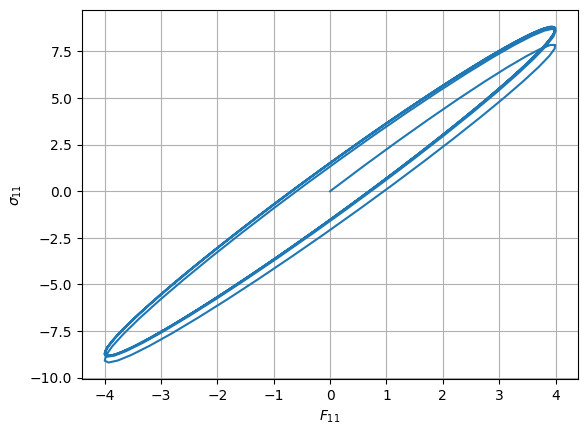

In [3]:
from simulation.simulate import simulate_unpack
from simulation.algebra import voigt_to_tensor, tensor_to_voigt

# ----------------- constitutive update (pure function) -----------------
def constitutive_update_fn(state_old, step_load, params):
    K, G, eta = params["K"], params["G"], params["eta"]

    eps      = step_load["epsilon"]         # (6,)
    deps     = step_load["delta_epsilon"]   # (6,)
    dt       = step_load["delta_t"]         # scalar
    sigma_n  = state_old["sigma"]           # (6,)

    # Volumetric (elastic)
    p = K * (eps[0] + eps[1] + eps[2])
    sigma_vol = jnp.array([p, p, p, 0.0, 0.0, 0.0], dtype=eps.dtype)

    # Deviatoric (Maxwell, Backward Euler)
    r = 1.0 / (1.0 + (G*dt)/eta)

    I = jnp.eye(3, dtype=eps.dtype)
    s_n = voigt_to_tensor(sigma_n)
    s_n_dev = s_n - jnp.trace(s_n)/3.0 * I

    dE = voigt_to_tensor(deps)
    dE_dev = dE - jnp.trace(dE)/3.0 * I

    s_np1_dev = r * (s_n_dev + 2.0*G * dE_dev)
    sigma_dev = tensor_to_voigt(s_np1_dev)

    sigma = sigma_vol + sigma_dev

    new_state = {"sigma": sigma}
    fields = {"sigma": sigma}
    logs = {}
    return new_state, fields, logs

# material params
E, nu = 1.0, 0.3
params = {
    "K": 1.0,
    "G": 1.0,
    "eta": 0.1
}

# strain history
n_ts = 200
ts = jnp.linspace(0., 1., n_ts)

# strain history (Voigt)
eps_xx = 4.0 * jnp.sin(ts * 30.0)
epsilon_ts = (jnp.zeros((len(ts), 6)).at[:, 0].set(eps_xx))

# Δt: first step = ts[1] - ts[0], then forward differences
dt0 = ts[1] - ts[0]
delta_t = jnp.concatenate([jnp.array([dt0]), jnp.diff(ts)])

# Δε: first step = 0, then forward differences along time
zero6 = jnp.zeros((1, 6), dtype=epsilon_ts.dtype)
delta_epsilon = jnp.concatenate([zero6, epsilon_ts[1:] - epsilon_ts[:-1]], axis=0)

load_ts = {
    "t": ts,                       # (T,)
    "epsilon": epsilon_ts,         # (T, 6)
    "delta_t": delta_t,            # (T,)
    "delta_epsilon": delta_epsilon # (T, 6)
}

state0 = {"sigma": jnp.zeros(6),}
state_T, fields_ts, state_ts, logs_ts = simulate_unpack(constitutive_update_fn,state0, load_ts, params)

eps11 = jnp.array(load_ts["epsilon"][:,0])
plt.plot(eps11,fields_ts["sigma"][:,0])
plt.grid()
plt.xlabel(r"$F_{11}$")
plt.ylabel(r"$\sigma_{11}$")
plt.show()

# plasticity example in uniaxial stress state



In [4]:
from jax import lax
from jax.scipy.linalg import solve as la_solve

from simulation.simulate import simulate_unpack
from simulation.algebra import dev_voigt, norm_voigt
from simulation.newton import newton_implicit_unravel



def C_iso_voigt(E, nu):
    mu  = E / (2.0 * (1.0 + nu))
    lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
    lam2 = lam + 2.0 * mu
    return jnp.array([
        [lam2, lam,  lam,  0., 0., 0.],
        [lam,  lam2, lam,  0., 0., 0.],
        [lam,  lam,  lam2, 0., 0., 0.],
        [0.,   0.,   0.,   mu, 0., 0.],
        [0.,   0.,   0.,   0., mu, 0.],
        [0.,   0.,   0.,   0., 0., mu],
    ])

def R_iso(p, params):
    return params["Q"] * (1.0 - jnp.exp(-params["b"] * p))

def vm(sigma):
    s = dev_voigt(sigma)
    return jnp.sqrt(3.0/2.0) * norm_voigt(s)

def f_func(sigma, p, params):
    return vm(sigma) - (params["sigma_y"] + R_iso(p, params))

# ----------------- constitutive residuals (dict in/out) -----------------
def residuals(x, epsilon, state_old, params, sigma_idx):

    C = C_iso_voigt(params["E"], params["nu"])
    sigma, eps_p, p, gamma = x["sigma"], x["eps_p"], x["p"], x["gamma"]
    eps_p_old, p_old = state_old["epsilon_p"], state_old["p"]

    X = x["X"]
    X_old = state_old["X"]

    # Contraintes : on remplace ε[eps_idx] par les inconnues eps_cstr
    epsilon_eff = epsilon.at[sigma_idx].set(x["eps_cstr"])

    # 1) relation élastique
    res_sigma = sigma - C @ (epsilon_eff - eps_p)

    # 2) direction de flux (autodiff) — plus de branchement ici
    df_dsigma = jax.grad(lambda s: f_func(s-X, p, params))(sigma)

    # 3) écoulement associé + cumul de plasticité
    res_epsp = (eps_p - eps_p_old) - gamma * df_dsigma
    res_p    = (p - p_old) - gamma

    # 4) contraintes sur sigma (σ[idx] = 0)
    res_cstr = sigma[sigma_idx]

    # 5) consistance plastique (Newton ne s'exécute que si on est en plastique)
    res_gamma = f_func(sigma-X, p, params)

    res_X = (X - X_old) - ( 2./3. * params['C_kin'] * (eps_p-eps_p_old) - params['D_kin'] * X * (p-p_old) )

    return {
        "res_sigma":  res_sigma,
        "res_epsp":   res_epsp,
        "res_p":      res_p,
        "res_X":      res_X,
        "res_gamma":  res_gamma,
        "res_cstr":   res_cstr,
    }

# ----------------- constitutive update (pure function) -----------------
def constitutive_update_fn(state_old, step_load, params, alg = {"tol" :1e-8, "abs_tol":1e-12, "max_it":100}):

    C = C_iso_voigt(params["E"], params["nu"])
    eps_p_old, p_old, X_old = state_old["epsilon_p"], state_old["p"], state_old["X"]
    dtype = C.dtype

    epsilon   = step_load["epsilon"]
    sigma_idx = step_load.get("sigma_cstr_idx")

    # ---------- 1) Constrained elastic trial (γ=0, εp=εp_old) ----------
    # Solve for z = eps_cstr_trial so that (C @ (epsilon_eff - eps_p_old))[sigma_idx] = 0
    # A @ (z - epsilon[eps_idx]) = - r
    A = C[sigma_idx][:, sigma_idx]                                                 # (k,k)
    r = (C @ (epsilon - eps_p_old))[sigma_idx]                                     # (k,)
    dz = la_solve(A, r, assume_a='gen')                                            # (k,)
    z  = epsilon[sigma_idx] - dz                                                   # eps_cstr_trial
    epsilon_eff_trial = epsilon.at[sigma_idx].set(z)
    sigma_trial       = C @ (epsilon_eff_trial - eps_p_old)

    # yield function at trial
    f_trial = f_func(sigma_trial-X_old, p_old, params)

    it_dtype = jnp.int32  # keep cond branches identical

    # ---------- 2) Elastic branch (skip Newton) ----------
    def elastic_branch(_):
        new_state = {"epsilon_p": eps_p_old, "p": p_old, "X": X_old}
        fields    = {"sigma": sigma_trial,"eps_cstr": z}
        logs      = {"conv": jnp.asarray(0, dtype=it_dtype)}
        return new_state, fields, logs

    # ---------- 3) Plastic branch (run Newton), init with the constrained trial ----------
    def plastic_branch(_):
        x0 = {
            "sigma":    sigma_trial,
            "eps_p":    eps_p_old,
            "p":        jnp.asarray(p_old, dtype=dtype),
            "X":        jnp.asarray(X_old, dtype=dtype),
            "gamma":    jnp.asarray(0.0, dtype=dtype),
            "eps_cstr": jnp.asarray(z, dtype=dtype),  # good initial guess
        }
        x_sol, iters = newton_implicit_unravel(
            residuals, x0, (epsilon, state_old, params, sigma_idx),
            tol=alg["tol"], abs_tol=alg["abs_tol"], max_iter=alg["max_it"]
        )
        new_state = {"epsilon_p": x_sol["eps_p"], "p": x_sol["p"], "X": x_sol["X"]}
        fields    = {"sigma": x_sol["sigma"],"eps_cstr": x_sol["eps_cstr"]}
        logs      = {"conv": jnp.asarray(iters, dtype=it_dtype)}
        return new_state, fields, logs

    # ---------- 4) Gate on f_trial ----------
    new_state, fields, logs = lax.cond(
        f_trial > 0.0,
        plastic_branch,
        elastic_branch,
        operand=None
    )
    return new_state, fields, logs



iter (first 100) [0 0 3 4 4 4 3 3 3 3 3 0 0 0 0 0 0 0 0 4 4 4 4 4 4 3 3 3 3 3 3 3 0 0 0 0 0
 0 0 0 0 4 4 4 4 4 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 3 3 3 3 3 3
 0 0 0 0 0 0 0 0 0 3 4 4 4 4 4 3 3 3 3 3 2 0 0 0 0 0]
eps_cstr (first 3) [[ 0.          0.          0.          0.          0.        ]
 [-0.18022007 -0.18022007  0.          0.          0.        ]
 [-0.3848536  -0.3848536   0.          0.          0.        ]]


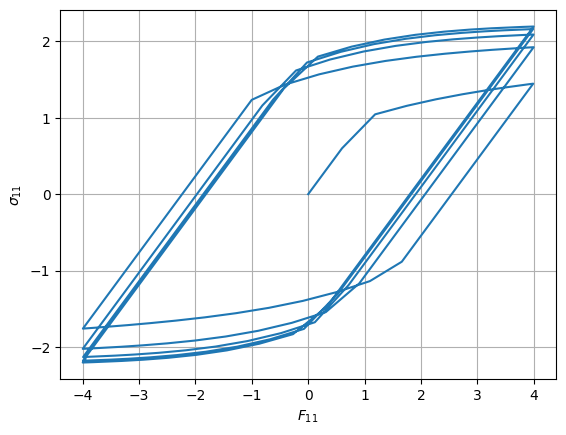

In [5]:
# material params
E, nu = 1.0, 0.3
params = {
    "sigma_y": 1.0,
    "Q": 1.0,
    "b": jnp.array(0.1),
    "C_kin": 0.25 ,
    "D_kin": 1.0 ,
    "E": 1.0,
    "nu": 0.3
}

# strain history
n_ts = 200
ts = jnp.linspace(0., 1., n_ts)
eps_xx = 4.0 * jnp.sin(ts * 30.0)
epsilon_ts = (jnp.zeros((len(ts), 6))
              .at[:, 0].set(eps_xx))

sigma_cstr_idx = jnp.asarray([1, 2, 3, 4, 5])

load_ts = {
    "epsilon": epsilon_ts,
    "sigma_cstr_idx": jnp.broadcast_to(sigma_cstr_idx, (len(ts), sigma_cstr_idx.shape[0])) ,
}

state0 = {"epsilon_p": jnp.zeros(6,), "p": jnp.array(0.0),"X": jnp.zeros(6,)}
state_T, fields_ts, state_ts, logs_ts = simulate_unpack(constitutive_update_fn,state0, load_ts, params)

print("iter (first 100)",logs_ts["conv"][:100])
print("eps_cstr (first 3)",fields_ts["eps_cstr"][:3,:])

eps11 = jnp.array(load_ts["epsilon"][:,0])
plt.plot(eps11,fields_ts["sigma"][:,0])
plt.grid()
plt.xlabel(r"$F_{11}$")
plt.ylabel(r"$\sigma_{11}$")
plt.show()

# More concise API

In [6]:
from simulation.simulate import make_simulate_unpack
from simulation.algebra import dev_voigt, norm_voigt, voigt_to_tensor, tensor_to_voigt


def Hooke_law_voigt(eps_e, E, nu):
    lam = E*nu / ((1 + nu) * (1 - 2*nu))
    mu  = E / (2 * (1 + nu))
    I = jnp.eye(3, dtype=eps_e.dtype)
    eps_e_tens = voigt_to_tensor(eps_e)
    sig_tens = lam*jnp.trace(eps_e_tens)*I+2*mu*eps_e_tens
    return tensor_to_voigt(sig_tens)

def R_iso(p, Q, b):
    return Q * (1.0 - jnp.exp(-b * p))

def vm(sigma):
    s = dev_voigt(sigma)
    return jnp.sqrt(3.0/2.0) * norm_voigt(s)

def f_func(sigma, p, sigma_y, Q, b):
    return vm(sigma) - (sigma_y + R_iso(p,Q,b))

def make_newton(state_old, step_load, params):

    epsilon = step_load["epsilon"]
    E, nu  = params["E"], params["nu"]
    sigma_y, Q, b = params["sigma_y"], params["Q"], params["b"]
    eps_p_old, p_old = state_old["epsilon_p"], state_old["p"]

    sigma_trial = Hooke_law_voigt(epsilon - eps_p_old, E, nu)
    f_trial     = f_func(sigma_trial, p_old, sigma_y, Q, b)

    def residuals(x):

        sigma, eps_p, p = x["sigma"], x["eps_p"], x["p"]

        H = jnp.heaviside(f_trial , 1.)

        res_sigma = sigma - Hooke_law_voigt(epsilon - eps_p, E, nu)

        df_dsigma = jax.grad(lambda s: f_func(s, p, sigma_y, Q, b))(sigma)
        res_epsp  = (eps_p - eps_p_old) - (p - p_old) * df_dsigma

        res_p = f_func(sigma, p, sigma_y, Q, b) * H + (1.0 - H) * (p - p_old)

        res = {"res_sigma": res_sigma, "res_epsp": res_epsp, "res_p": res_p}

        return res

    def initialize():

        return { "sigma": sigma_trial, "eps_p": eps_p_old, "p": jnp.asarray(p_old) }

    def unpack(x): # we need to redefine the structure as jax does not accept mutations

        state = {"epsilon_p": x["eps_p"], "p": x["p"]}
        fields    = {"sigma": x["sigma"]}

        return state, fields

    return residuals, initialize, unpack

epsilon_ts.dtype float64
iteration count (first 100) [1 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1]


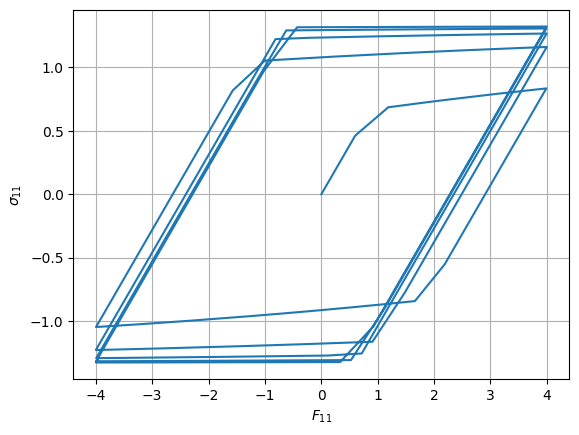

In [7]:
# material params
E, nu = 1.0, 0.3
params = {
    "sigma_y": 1.0,
    "Q": 1.0,
    "b": jnp.array(0.1),
    "E" : 1.0,
    "nu": 0.3,
}

# strain history
n_ts = 200
ts = jnp.linspace(0., 1., n_ts)
eps_xx = 4.0 * jnp.sin(ts * 30.0)
epsilon_ts = (jnp.zeros((n_ts, 6))
              .at[:, 0].set(eps_xx)
              .at[:, 1].set(-0.5 * eps_xx)
              .at[:, 2].set(-0.5 * eps_xx))

print("epsilon_ts.dtype",epsilon_ts.dtype)

load_ts={"epsilon": epsilon_ts}

state0 = {"epsilon_p": jnp.zeros(6), "p": jnp.array(0.0)}
state_T, fields_ts, state_ts, logs_ts = make_simulate_unpack(make_newton, state0, load_ts, params)

print("iteration count (first 100)",logs_ts["conv"][:100])

eps11 = jnp.array(load_ts["epsilon"][:,0])
plt.plot(eps11,fields_ts["sigma"][:,0])
plt.grid()
plt.xlabel(r"$F_{11}$")
plt.ylabel(r"$\sigma_{11}$")
plt.show()

# Basic calibration example : find the two parameters of an exponential isotropic hardening law $R(p)=Q(1-e^{-bp})$

In [8]:
from jax import lax, jit
from jax.scipy.linalg import solve as la_solve

from simulation.simulate import simulate
from simulation.algebra import dev_voigt, norm_voigt
from optimization.optimizers import bfgs
from optimization.parameter_mappings import build_param_space, make_loss, to_params

# save reference solution for inverse problem
true_params = params.copy()
sigma_xx_obs = fields_ts["sigma"][:, 0]

In [9]:
print("-----------------------------------------------")
print("active/frozen parameter ranges and distribution")
print("-----------------------------------------------")


# --- declare frozen + active (bounds + scale). Omit values in init_params to use interval midpoints ---
init_params = {
    "E": 1.0, "nu": 0.3, "sigma_y": 1.0,  # frozen values supplied
    # "Q": (omitted -> defaults to geom. mean of bounds)
    # "b": (omitted -> defaults to geom. mean of bounds)
    "C_kin": 0.25, "D_kin": 1.0,          # frozen for this example
}

active_specs = {
    "E": False, "nu": False, "sigma_y": False, "C_kin": False, "D_kin": False,
    "Q": {"lower": 1.e-3, "upper": 1.e+2, "scale": "log", "mask": None},
    "b": {"lower": 1.e-3, "upper": 1.e+0, "scale": "log", "mask": None},
}

space, theta0 = build_param_space(init_params, active_specs)


print("-----------------")
print("user-defined loss")
print("-----------------")


def forward_sigma11(params):
    #state0 = {"epsilon_p": jnp.zeros(6), "p": jnp.array(0.0), "X": jnp.zeros(6)}
    #_, saved = simulate(constitutive_update_fn, state0, load_ts, params)
    state_T, fields_ts, state_ts, logs_ts = make_simulate_unpack(make_newton,state0, load_ts, params)
    return fields_ts["sigma"][:, 0]

def simulate_and_loss(params):
    pred = forward_sigma11(params)
    r = pred - sigma_xx_obs
    return 0.5 * jnp.mean(r * r)

loss = make_loss(space,simulate_and_loss)

-----------------------------------------------
active/frozen parameter ranges and distribution
-----------------------------------------------
-----------------
user-defined loss
-----------------


-------------
run optimizer
-------------
Initial Q, b: 0.31622776601683805 0.0316227766016838
[BFGS] it 0: f=8.793365e-02, ||g||=2.189e-01
[BFGS] it 1: f=2.434254e-03, ||g||=2.778e-02, alpha=1.500e+00, fe=4, ge=4
[BFGS] it 2: f=2.390029e-03, ||g||=2.779e-02, alpha=2.500e-01, fe=7, ge=7
[BFGS] it 3: f=2.190257e-03, ||g||=1.192e-02, alpha=1.000e+00, fe=8, ge=8
[BFGS] it 4: f=1.753213e-03, ||g||=3.507e-02, alpha=1.000e+00, fe=9, ge=9
[BFGS] it 5: f=1.549339e-03, ||g||=1.868e-02, alpha=1.000e+00, fe=10, ge=10
[BFGS] it 6: f=1.027698e-03, ||g||=2.511e-02, alpha=1.000e+00, fe=11, ge=11
[BFGS] it 7: f=9.015357e-04, ||g||=1.267e-02, alpha=1.000e+00, fe=12, ge=12
[BFGS] it 8: f=6.109970e-04, ||g||=3.091e-02, alpha=1.000e+00, fe=13, ge=13
[BFGS] it 9: f=5.154792e-04, ||g||=1.709e-02, alpha=1.000e+00, fe=14, ge=14
[BFGS] it 10: f=3.828846e-04, ||g||=1.164e-02, alpha=1.000e+00, fe=15, ge=15
[BFGS] it 11: f=2.939319e-04, ||g||=1.534e-02, alpha=1.000e+00, fe=16, ge=16
[BFGS] it 12: f=2.441304e-04, 

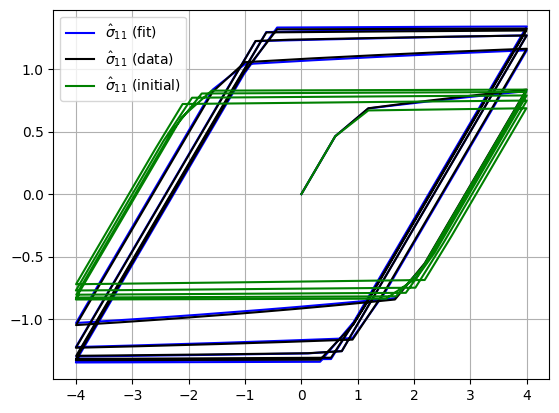

In [10]:
print("-------------")
print("run optimizer")
print("-------------")

init = to_params(space, theta0)
print("Initial Q, b:", init["Q"], init["b"])

# --- run BFGS (optionally seed with a few Adam steps you have) ---
t0 = time.perf_counter()
theta_opt, fval, info = bfgs(loss, theta0, rtol=1.e-3, n_display=1)
t1 = time.perf_counter()
print("time for optimizaton:", (t1 - t0), "s")
print("final loss:", fval)
print("info",info)

# --- unpack physical identified parameters ---
identified = to_params(space, theta_opt)
print("Identified Q, b:", identified["Q"], identified["b"])
# Optional: get fitted curve

print("-----------")
print("plot result")
print("-----------")


sigma_fit = forward_sigma11(identified)
sigma_init = forward_sigma11(init)

plt.plot(load_ts['epsilon'][:,0],sigma_fit,'blue',label=r'$\hat{\sigma}_{11}$ (fit)')
plt.plot(load_ts['epsilon'][:,0],sigma_xx_obs,'black',label=r'$\hat{\sigma}_{11}$ (data)')
plt.plot(load_ts['epsilon'][:,0],sigma_init,'green',label=r'$\hat{\sigma}_{11}$ (initial)')
plt.legend(loc='best')
plt.grid()
plt.show()

In [11]:
print("--------------")
print("test CPU times")
print("--------------")

v_ = loss(theta0).block_until_ready()
_ = jax.grad(loss)(theta0).block_until_ready()  # warm both paths

t0 = time.perf_counter()
f = loss(theta0).block_until_ready()
t1 = time.perf_counter()
print("one forward loss eval:", (t1 - t0) * 1e3, "ms")

t0 = time.perf_counter()
g = jax.grad(loss)(theta0).block_until_ready()
t1 = time.perf_counter()
print("one grad eval:", (t1 - t0) * 1e3, "ms")

--------------
test CPU times
--------------
one forward loss eval: 22.110948999994662 ms
one grad eval: 37.88990500001432 ms


# Advanced : Bayesian inference (MALA)

--------------
mala for prior
--------------
MALA acceptance rate: 0.9866666793823242


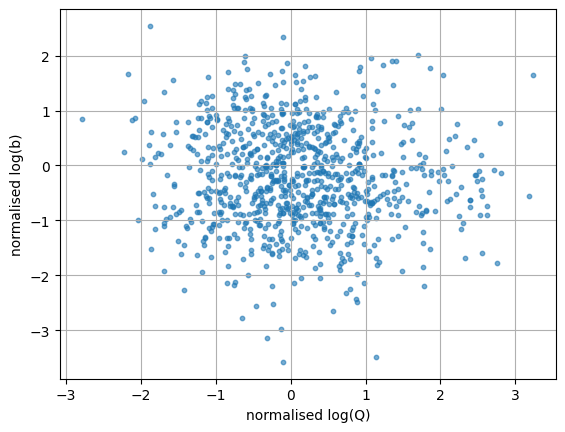

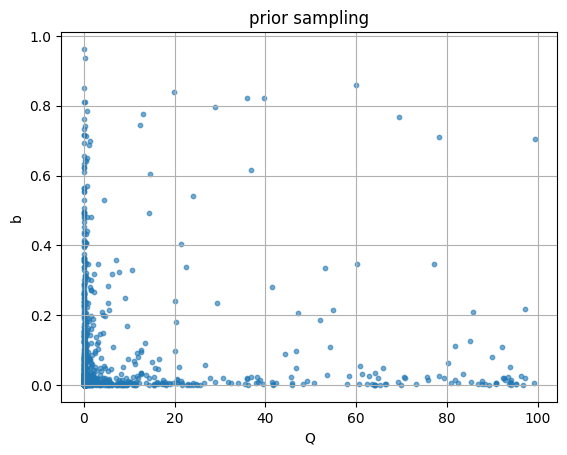

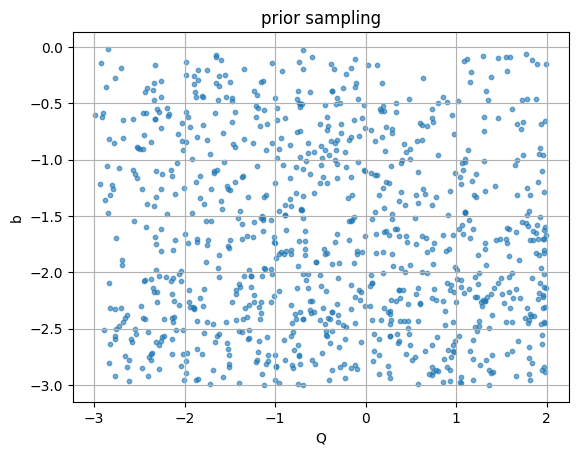

In [12]:
from optimization.samplers import *
from functools import partial

print("--------------")
print("mala for prior")
print("--------------")


def loglik(theta):
    # Drop the normalization constant (it doesn't depend on theta and cancels in MALA/MH).
    # i.i.d. N(0, σ^2): log p(y|θ,σ) = const - (1/(σ^2)) * 0.5*sum r^2
    noise_std = 1.e6
    return -(0.5 / (noise_std**2)) * loss(theta)

run_mala = make_mala_unit_gaussian_prior(loglik)

key = random.PRNGKey(0)
samples, acc_rate = run_mala(
    key,
    theta0,         # starting point, shape [d]
    eps=0.5,
    n_steps=1000,
    burn=100,
    thin=1,
)

print("MALA acceptance rate:", float(acc_rate))

import numpy as np
pts = np.asarray(samples, dtype=np.float32)
plt.scatter(pts[:,0],pts[:,1], s=10, alpha=0.6)
plt.xlabel('normalised log(Q)')
plt.ylabel('normalised log(b)')
plt.grid()
plt.show()


params = map_to_params(space, samples)

Q = jax.device_get(params["Q"]).ravel()
b = jax.device_get(params["b"]).ravel()

plt.figure()
plt.scatter(Q, b, s=10, alpha=0.6)  # x=Q, y=b
plt.xlabel("Q")
plt.ylabel("b")
plt.grid(True)
plt.title('prior sampling')
plt.show()

plt.figure()
plt.scatter(jnp.log10(Q), jnp.log10(b), s=10, alpha=0.6)  # x=Q, y=b
plt.xlabel("Q")
plt.ylabel("b")
plt.grid(True)
plt.title('prior sampling')
plt.show()

------------------
mala for posterior
------------------
MALA acceptance rate: 0.7222222685813904


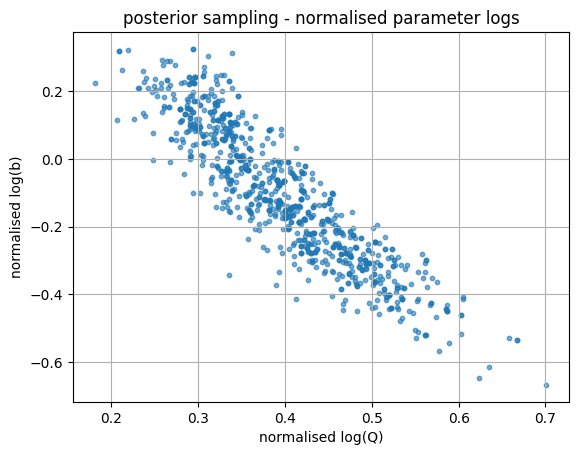

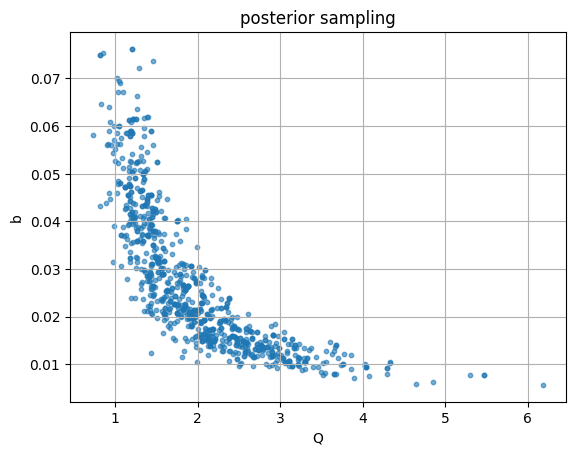

------------------------------------------------
parameter summaries and predictive distributions
------------------------------------------------
param_summ (Array(0.02732989, dtype=float64), Array(0.01023741, dtype=float64), Array(0.05800961, dtype=float64))
param_summ (Array(1.98427127, dtype=float64), Array(1.10072019, dtype=float64), Array(3.3497816, dtype=float64))


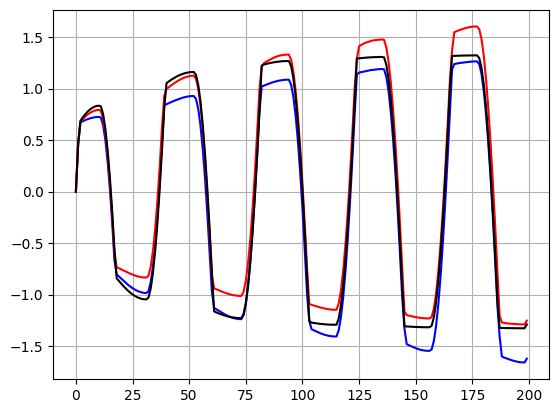

In [13]:
print("------------------")
print("mala for posterior")
print("------------------")

def loglik(theta):
    # Drop the normalization constant (it doesn't depend on theta and cancels in MALA/MH).
    # i.i.d. N(0, σ^2): log p(y|θ,σ) = const - (1/(σ^2)) * 0.5*sum r^2
    noise_std = 5.e-2
    return -(0.5 / (noise_std**2)) * loss(theta)

run_mala = make_mala_unit_gaussian_prior(loglik)

key = random.PRNGKey(0)
samples, acc_rate= run_mala(
    key,
    theta0,
    eps=5.e-2,
    n_steps=1000,
    burn=100,
    thin=1,
)

print("MALA acceptance rate:", float(acc_rate))



import numpy as np
pts = np.asarray(samples, dtype=np.float32)
plt.scatter(pts[:,0],pts[:,1], s=10, alpha=0.6)
plt.xlabel('normalised log(Q)')
plt.ylabel('normalised log(b)')
plt.grid()
plt.title('posterior sampling - normalised parameter logs')
plt.show()

params = map_to_params(space, samples)

Q = jax.device_get(params["Q"]).ravel()
b = jax.device_get(params["b"]).ravel()

plt.figure()
plt.scatter(Q, b, s=10, alpha=0.6)  # x=Q, y=b
plt.xlabel("Q")
plt.ylabel("b")
plt.grid(True)
plt.title('posterior sampling')
plt.show()


print("------------------------------------------------")
print("parameter summaries and predictive distributions")
print("------------------------------------------------")

# Posterior summaries in parameter space (dict: name -> (mean, p05, p95))
param_summ = posterior_param_summary(samples, space)
# Returns a dict: {name: (mean, p05, p95)}
print("param_summ",param_summ['b'])
print("param_summ",param_summ['Q'])

# Predictive band for σ11(t)
sigma_mean, sigma_p05, sigma_p95, sigma_samples = posterior_predictive(samples,space,forward_sigma11)

# Example: if you want the posterior mean physical-parameter dict:
# mean_params = jax.tree_map(lambda trio: trio[0], param_summ)

plt.plot(sigma_p05,'blue')
plt.plot(sigma_p95,'red')
plt.plot(sigma_xx_obs,'black')
plt.grid()
plt.show()